# MLP 多层感知机模型

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

判断员工是否离职left（二分类）

## 1.数据预处理

In [2]:
data = pd.read_csv('HR.csv')

In [3]:
data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,part,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [4]:
# 分组观察数据
data.groupby(['salary', 'part']).size()

salary  part       
high    IT               83
        RandD            51
        accounting       74
        hr               45
        management      225
        marketing        80
        product_mng      68
        sales           269
        support         141
        technical       201
low     IT              609
        RandD           364
        accounting      358
        hr              335
        management      180
        marketing       402
        product_mng     451
        sales          2099
        support        1146
        technical      1372
medium  IT              535
        RandD           372
        accounting      335
        hr              359
        management      225
        marketing       376
        product_mng     383
        sales          1772
        support         942
        technical      1147
dtype: int64

### one-hot处理

In [5]:
# one hot encode，将离散特征取值转换为一种状态，从离散值转为激活态
pd.get_dummies(data.salary)

,high,low,medium
0,0,1,0
1,0,0,1
2,0,0,1
3,0,1,0
4,0,1,0
...,...,...,...
14994,0,1,0
14995,0,1,0
14996,0,1,0
14997,0,1,0


In [6]:
data = data.join(pd.get_dummies(data.salary))
del data['salary']
data = data.join(pd.get_dummies(data.part))
del data['part']

In [7]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,high,low,...,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


### 注意：数据目标值分布不均匀，模型准确率有最低要求

In [8]:
data.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [9]:
# 准确率不应低于
11428/len(data)

0.7619174611640777

### 提取特征值、目标值

In [10]:
Y_data = data.left.values.reshape(-1,1)
Y = torch.from_numpy(Y_data).type(torch.float32)

In [11]:
X_data = data[[c for c in data.columns if c!='left']].values
X = torch.from_numpy(X_data).type(torch.float32)

In [12]:
X.size()

torch.Size([14999, 20])

## 3.创建模型（自定义模型）
### 自定义模型：

nn.Module：继承这个类

__init__方法：初始化所有层

forward方法：定义前向传播过程

In [13]:
from torch import nn

In [14]:
class Model_1(nn.Module):
    # 初始化方法
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(20, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, 1)
        # 无参数层
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    # 前向传播方法
    def forward(self, input):
        x = self.linear_1(input)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.linear_3(x)
        x = self.sigmoid(x)
        return x

In [15]:
model = Model_1()

In [16]:
model

Model_1(
  (linear_1): Linear(in_features=20, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=64, bias=True)
  (linear_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

### 另一种自定义模型方法，使用更低级的模块nn.functional（自然，推荐）

In [17]:
import torch.nn.functional as F

In [18]:
class Model_2(nn.Module):
    # 初始化方法
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(20, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, 1)
    
    # 前向传播方法（重写）
    def forward(self, input):
        x = F.relu(self.linear_1(input))
        x = F.relu(self.linear_2(x))
        x = self.linear_3(x)
        x = torch.sigmoid(x)  # torch.sigmoid和F.sigmoid没有区别，推荐使用前者
        return x

In [19]:
model = Model_2()

In [20]:
model

Model_2(
  (linear_1): Linear(in_features=20, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=64, bias=True)
  (linear_3): Linear(in_features=64, out_features=1, bias=True)
)

### 定义 获取模型方法，包含模型、目标函数

In [21]:
def get_model():
    model = Model_2()
    optim = torch.optim.Adam(model.parameters(),lr=0.0001)
    return model, optim

In [22]:
model, opt = get_model()

### 定义 损失函数

In [23]:
loss_fn = nn.BCELoss()

### 定义 正确率计算函数

In [24]:
def accuarcy(y_pred, y_true):
    return ((y_pred > 0.5).type(torch.int32) == y_true).float().mean()

## 4.训练模型

In [25]:
batch = 64
num_batches = len(data)//batch
epochs = 100

In [26]:
epoch_m = []
loss_m = []
acc_m = []

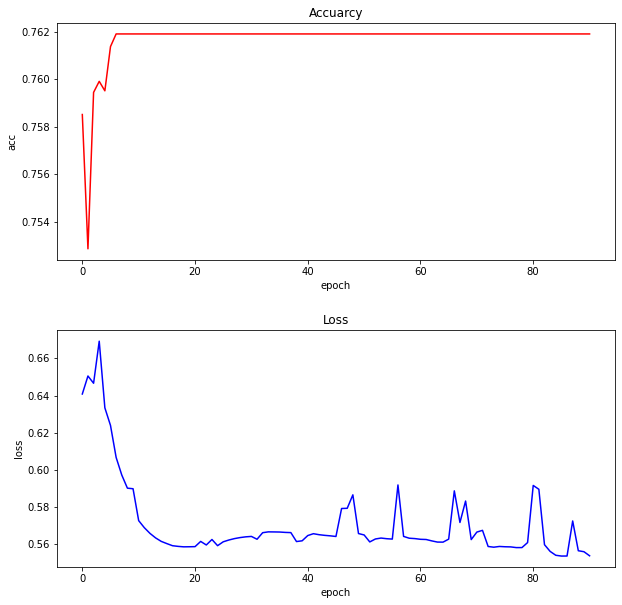

In [27]:
for epoch in range(epochs):
    for i in range(num_batches):
        start = i*batch
        end = start + batch
        x = X[start: end]
        y = Y[start: end]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    # 绘制损失图、准确率图
    with torch.no_grad():
        epoch_m.append(epoch)
        loss_m.append(loss_fn(model(X), Y).item())
        acc_m.append(accuarcy(model(X), Y).item())
        
        if epoch%10 is 0:
            plt.subplot(2, 1, 1)
            plt.title('Accuarcy')
            plt.xlabel('epoch')
            plt.ylabel('acc')
            plt.plot(epoch_m, acc_m, c='r')
            
            plt.subplot(2, 1, 2)
            plt.title('Loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.plot(epoch_m, loss_m, c='b')
            
            plt.rcParams['figure.figsize'] = (10, 10)
            plt.subplots_adjust(hspace=0.3)
            plt.show()
            
            from IPython import display
            display.clear_output(wait=True)

## ~以下为优化部分~

## 使用dataset类,dataloader类进行重构

TensorDataset

In [28]:
from torch.utils.data import TensorDataset

In [29]:
HR_ds = TensorDataset(X, Y)

In [30]:
HR_ds[2: 5]  # 返回一个元组（X，Y）

(tensor([[1.1000e-01, 8.8000e-01, 7.0000e+00, 2.7200e+02, 4.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 0.0000e+00],
         [7.2000e-01, 8.7000e-01, 5.0000e+00, 2.2300e+02, 5.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.7000e-01, 5.2000e-01, 2.0000e+00, 1.5900e+02, 3.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 0.0000e+00]]), tensor([[1.],
         [1.],
         [1.]]))

DataLoader

In [46]:
from torch.utils.data import DataLoader

In [47]:
HR_dl = DataLoader(HR_ds, batch_size=batch, shuffle=True)  # 为了避免样本顺序影响模型，shuffle乱序载入数据集HR_ds

## 使用sklearn, 划分训练集、测试集

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
train_x, test_x, train_y, test_y = train_test_split(X_data, Y_data)

In [50]:
train_x = torch.from_numpy(train_x).type(torch.float32)
train_y = torch.from_numpy(train_y).type(torch.float32)
test_x = torch.from_numpy(test_x).type(torch.float32)
test_y = torch.from_numpy(test_y).type(torch.float32)

In [51]:
train_ds = TensorDataset(train_x, train_y)
train_dl = DataLoader(train_ds, batch_size=batch, shuffle=True)

In [52]:
test_ds = TensorDataset(test_x, test_y)
test_dl = DataLoader(test_ds, batch_size=batch)

## 重构后训练模型

In [53]:
model, opt = get_model()

In [54]:
epoch_m = []
acc_train_m = []
loss_train_m = []
acc_test_m = []
loss_test_m = []

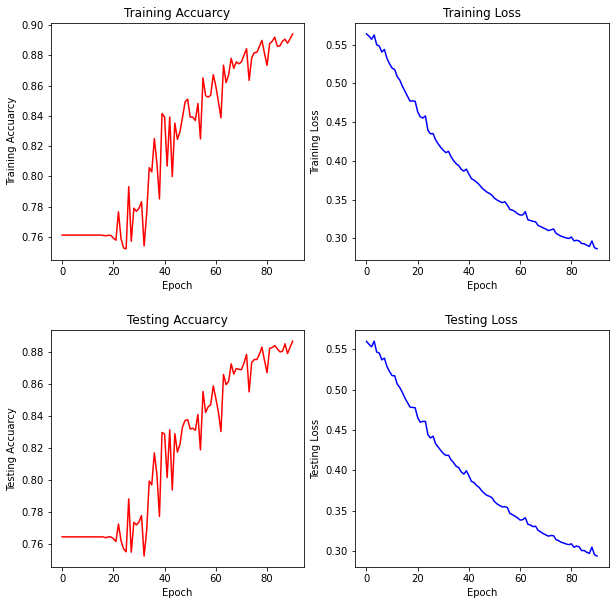

In [55]:
for epoch in range(epochs):
    for x, y in train_dl:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    # 绘制损失图、准确率图
    with torch.no_grad():
        epoch_m.append(epoch)
        loss_train_m.append(loss_fn(model(train_x), train_y).item())
        acc_train_m.append(accuarcy(model(train_x), train_y).item())
        loss_test_m.append(loss_fn(model(test_x), test_y).item())
        acc_test_m.append(accuarcy(model(test_x), test_y).item())
        
        if epoch%10 is 0:
            plt.subplot(2, 2, 1)
            plt.title('Training Accuarcy')
            plt.xlabel('Epoch')
            plt.ylabel('Training Accuarcy')
            plt.plot(epoch_m, acc_train_m, c='r')
            
            plt.subplot(2, 2, 2)
            plt.title('Training Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Training Loss')
            plt.plot(epoch_m, loss_train_m, c='b')
            
            plt.subplot(2, 2, 3)
            plt.title('Testing Accuarcy')
            plt.xlabel('Epoch')
            plt.ylabel('Testing Accuarcy')
            plt.plot(epoch_m, acc_test_m, c='r')
            
            plt.subplot(2, 2, 4)
            plt.title('Testing Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Testing Loss')
            plt.plot(epoch_m, loss_test_m, c='b')
            
            plt.rcParams['figure.figsize'] = (10, 10)
            plt.subplots_adjust(hspace=0.3)
            plt.show()
            
            from IPython import display
            display.clear_output(wait=True)